In [1]:
pip install iisignature

In [2]:
import iisignature
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def generate_words(alphabet, max_order, include_empty=True):
    """
    Génère les mots de l'alphabet donné jusqu'au max_order.

    Paramètres :
      - alphabet : liste ou tuple des symboles (par exemple [1, 2])
      - max_order : l'ordre maximum des mots (exclut le mot vide si include_empty=False)
      - include_empty : inclure le mot vide () au début (True par défaut)

    Retourne :
      - une liste de tuples représentant les mots dans l'ordre gradué lexicographique.
    """
    words = []
    if include_empty:
        words.append(())
    for order in range(1, max_order + 1):
        # itertools.product génère tous les produits cartésiens de longueur 'order'
        for word in itertools.product(alphabet, repeat=order):
            words.append(word)
    return words

In [4]:
def exp_shuffle(letter  , scalar , degree_max,words) :
  d={}
  for i in range(len(words)):
    d[words[i]]=0
  for i in range (degree_max) :
    d[(letter,)*i] = scalar **i
  return d

In [5]:
def concat(a , b ,words):
  result = {}
  for i in range(len(words)):
    result[words[i]]=0
  for item1 in a.keys() :
    for item2 in b.keys() :
      if item1+item2 in words :
        result[item1+item2]= result[item1+item2] + a[item1] * b[item2]
  return result

In [6]:
def add(a,b,words) :
  result = {}
  for i in range(len(words)):
    result[words[i]]=0
  for item in words :
    result[item] = a[item] + b[item]
  return result

In [7]:
def create_empty(m,words) :
  empty_dic={}
  for i in range(len(words)):
    empty_dic[words[i]]=0
  return empty_dic

In [8]:
def l_hat_at_t(t,m,words):
  l_hat = create_empty(m,words)
  l_hat[()] = theta + np.exp(-kappa*t) * (x0-theta)
  word_2 =create_empty(m,words)
  word_2[(2,)] = eta * np.exp(-kappa * t)
  exp_shuffle_word = exp_shuffle(1,kappa,m,words)
  c=concat(exp_shuffle_word,word_2,words)
  l_hat = add(l_hat, c,words)
  return l_hat


In [17]:
# Parameters
x0 = 0.2
kappa = 4
theta = 0.25
eta = 2
T = 1
dt = 0.001

# Number of time steps and time grid
N = int(T / dt)
t = np.linspace(0, T, N + 1)

# Number of Monte Carlo simulations
N_sim = 100000

In [18]:
# Each row corresponds to one simulation, each column to one time point
X_paths = np.zeros((N_sim, N + 1))
# Optionally, store the Brownian increments (each row for one simulation)
dW_matrix = np.zeros((N_sim, N))

# Monte Carlo simulation loop
for i in range(N_sim):
    # Generate Brownian increments for one simulation
    dW = np.sqrt(dt) * np.random.randn(N)
    dW_matrix[i, :] = dW

    # Initialize the OU process path for this simulation
    X = np.zeros(N + 1)
    X[0] = x0

    # Euler–Maruyama scheme for the OU process
    for j in range(1, N + 1):
        X[j] = X[j - 1] + kappa * (theta - X[j - 1]) * dt + eta * dW[j - 1]

    # Save the full path into the X_paths array
    X_paths[i, :] = X


# Optionally, calculate the mean path over time (averaging over simulations)
mean_path = np.mean(X_paths, axis=0)

dW=np.mean(dW_matrix,axis=0)
W = np.zeros(N + 1)
W[1:] = np.cumsum(dW)
path = np.column_stack((t, W))

In [19]:
t.shape

(1001,)

In [20]:
def plot_ou(max_order,d) :
  plt.figure(figsize=(10, 6))
  plt.plot(t,mean_path,label="MC PATH")
  alphabet = [i for i in range(1,d+1)]
  for m in range(2,max_order+1) :
    words = generate_words(alphabet, m)
    l = l_hat_at_t(t,m,words)
    OU= np.zeros_like(t)
    OU[0]=x0
    signature_length = iisignature.siglength(d,m) + 1
    for i in range(1,N+1) :
      signature = iisignature.sig(path[:i,:], m)
      dic=create_empty(m,words)
      dic[()]=1
      for j in range(1,signature_length) :
        dic[words[j]]=signature[j-1]
      S=0
      l=l_hat_at_t(t[i],m,words)
      for key in dic.keys() :
        S=S+l[key]*dic[key]

      OU[i]=S
    plt.plot(t,OU,label = str(m))
  plt.legend()
  plt.show()


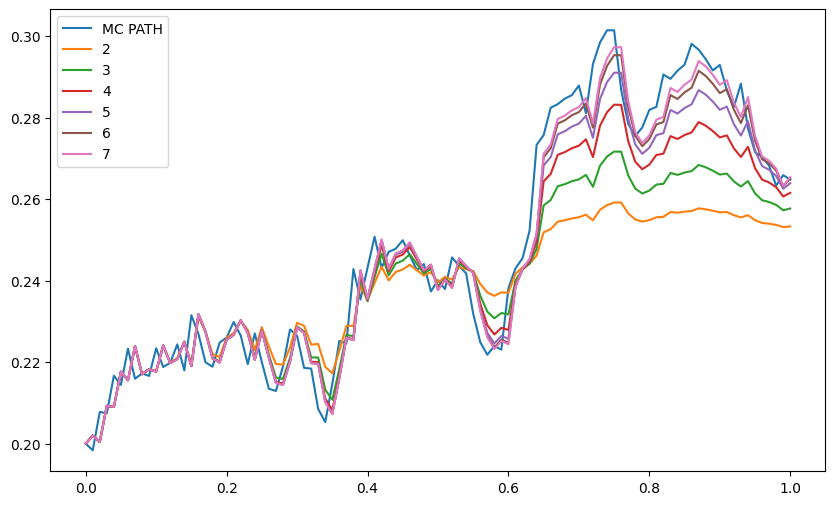

In [16]:
plot_ou(7,2)